<a href="https://colab.research.google.com/github/Anik85/Anik85/blob/main/resnet_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d erhmrai/ecg-image-data

100% 858M/858M [00:41<00:00, 23.8MB/s]
100% 858M/858M [00:41<00:00, 21.9MB/s]


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/ecg-image-data.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import preprocess_input,VGG16
from glob import glob
from sklearn.metrics import confusion_matrix, classification_report

(288, 432, 4)


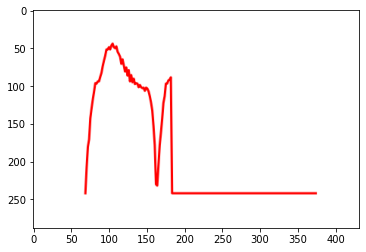

In [5]:
import cv2
path =r'/content/ECG_Image_data/test/S/S1070.png'
x=plt.imread(path)
print(x.shape)
plt.imshow(x)

In [6]:
train_dir = Path('/content/ECG_Image_data/train')

filepaths = list(train_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

,Filepath,Label
0,/content/ECG_Image_data/train/Q/Q1039.png,Q
1,/content/ECG_Image_data/train/Q/Q7206.png,Q
2,/content/ECG_Image_data/train/Q/Q367.png,Q
3,/content/ECG_Image_data/train/Q/Q4548.png,Q
4,/content/ECG_Image_data/train/Q/Q6629.png,Q
...,...,...
99194,/content/ECG_Image_data/train/M/M2469.png,M
99195,/content/ECG_Image_data/train/M/M5724.png,M
99196,/content/ECG_Image_data/train/M/M8708.png,M
99197,/content/ECG_Image_data/train/M/M9175.png,M


In [7]:
dataframe['Label'].value_counts()

N    75709
M     8405
Q     6431
V     5789
S     2223
F      642
Name: Label, dtype: int64

In [8]:
samples = []
for category in dataframe['Label'].unique():
    category_slice = dataframe.query("Label == @category")
    samples.append(category_slice.sample(640, random_state=1))

dataframe_train = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

Q    640
S    640
N    640
M    640
F    640
V    640
Name: Label, dtype: int64

In [9]:
dataframe_train

,Filepath,Label
0,/content/ECG_Image_data/train/Q/Q6407.png,Q
1,/content/ECG_Image_data/train/S/S1238.png,S
2,/content/ECG_Image_data/train/N/N10626.png,N
3,/content/ECG_Image_data/train/N/N92838.png,N
4,/content/ECG_Image_data/train/M/M8289.png,M
...,...,...
3835,/content/ECG_Image_data/train/N/N4068.png,N
3836,/content/ECG_Image_data/train/F/F40.png,F
3837,/content/ECG_Image_data/train/F/F799.png,F
3838,/content/ECG_Image_data/train/Q/Q2081.png,Q


In [10]:
test_dir = Path('/content/ECG_Image_data/test')

filepaths = list(test_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_test = pd.concat([filepaths , labels] , axis=1)
dataframe_test

,Filepath,Label
0,/content/ECG_Image_data/test/Q/Q2513.png,Q
1,/content/ECG_Image_data/test/Q/Q5854.png,Q
2,/content/ECG_Image_data/test/Q/Q7493.png,Q
3,/content/ECG_Image_data/test/Q/Q3968.png,Q
4,/content/ECG_Image_data/test/Q/Q2804.png,Q
...,...,...
24794,/content/ECG_Image_data/test/M/M1245.png,M
24795,/content/ECG_Image_data/test/M/M935.png,M
24796,/content/ECG_Image_data/test/M/M646.png,M
24797,/content/ECG_Image_data/test/M/M400.png,M


In [11]:
dataframe_test['Label'].value_counts()

N    18926
M     2101
Q     1608
V     1447
S      556
F      161
Name: Label, dtype: int64

In [12]:
samples = []
for category in dataframe_test['Label'].unique():
    category_slice = dataframe_test.query("Label == @category")
    samples.append(category_slice.sample(160, random_state=1))

dataframe_test = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_test['Label'].value_counts()

F    160
M    160
S    160
Q    160
V    160
N    160
Name: Label, dtype: int64

In [13]:
dataframe_test

,Filepath,Label
0,/content/ECG_Image_data/test/F/F309.png,F
1,/content/ECG_Image_data/test/M/M1867.png,M
2,/content/ECG_Image_data/test/S/S1423.png,S
3,/content/ECG_Image_data/test/S/S1021.png,S
4,/content/ECG_Image_data/test/S/S2257.png,S
...,...,...
955,/content/ECG_Image_data/test/N/N26117.png,N
956,/content/ECG_Image_data/test/Q/Q119.png,Q
957,/content/ECG_Image_data/test/M/M1906.png,M
958,/content/ECG_Image_data/test/F/F184.png,F


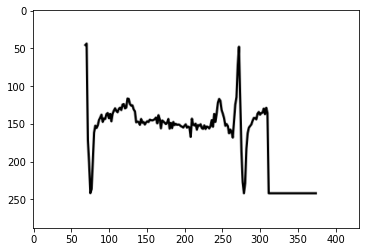

In [14]:
from keras.utils import img_to_array,load_img
img = load_img(dataframe_test['Filepath'].values[1])
plt.imshow(img)
plt.axis("on")
plt.show()

In [15]:
array_image = img_to_array(img)
print(array_image.shape)

(288, 432, 3)


In [16]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rescale=1./255,
    validation_split=0.2
  
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rescale=1./255
)
'''
train_datagen = ImageDataGenerator(rescale= 1./255,
                   shear_range = 0.2,
                   horizontal_flip=True,
                   zoom_range = 0.2,
                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale= 1./255)'''


'\ntrain_datagen = ImageDataGenerator(rescale= 1./255,\n                   shear_range = 0.2,\n                   horizontal_flip=True,\n                   zoom_range = 0.2,\n                   validation_split=0.2)\n\ntest_datagen = ImageDataGenerator(rescale= 1./255)'

In [17]:
size=224
color_mode='rgb'
batch_size=32
train_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)
'''

train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size= (224,224),
        batch_size = 32,
        color_mode= "rgb",
        subset='training',
        class_mode= "categorical")
val_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size= (224,224),
        batch_size = 32,
        color_mode= "rgb",
        subset='validation',
        class_mode= "categorical")
test_generator = test_datagen.flow_from_directory(
        test_dir, 
        target_size= (224,224),
        batch_size = 32,
        color_mode= "rgb",
        class_mode= "categorical")'''

Found 3072 validated image filenames belonging to 6 classes.
Found 768 validated image filenames belonging to 6 classes.
Found 960 validated image filenames belonging to 6 classes.


'\n\ntrain_generator = train_datagen.flow_from_directory(\n        train_dir, \n        target_size= (224,224),\n        batch_size = 32,\n        color_mode= "rgb",\n        subset=\'training\',\n        class_mode= "categorical")\nval_generator = train_datagen.flow_from_directory(\n        train_dir, \n        target_size= (224,224),\n        batch_size = 32,\n        color_mode= "rgb",\n        subset=\'validation\',\n        class_mode= "categorical")\ntest_generator = test_datagen.flow_from_directory(\n        test_dir, \n        target_size= (224,224),\n        batch_size = 32,\n        color_mode= "rgb",\n        class_mode= "categorical")'

In [19]:
for data_batch, labels_batch in train_images:
    print("data_batch shape --> ",data_batch.shape)
    print("labels_batch shape --> ",labels_batch.shape)
    break

data_batch shape -->  (32, 224, 224, 3)
labels_batch shape -->  (32, 6)


In [20]:
test_images.class_indices

{'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}

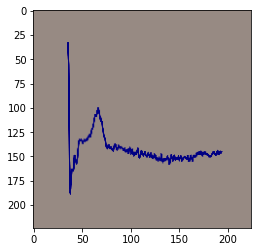

In [21]:
plt.imshow(test_images[0][0][3])

In [22]:
'''IMAGE_SIZE = [224, 224]


resnet = ResNet50(
    input_shape = IMAGE_SIZE + [3], 
    weights = 'imagenet', 
    include_top = False  
)'''
pretrained_model = ResNet50(
                              input_shape=(224,224,3),
                              include_top= False,
                              weights='imagenet',
                              pooling='avg'
                              )

pretrained_model.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
#for layer in resnet.layers:
 #   layer.trainable = False

In [ ]:
#folders = glob('/content/ECG_Image_data/train/*')
#folders

In [ ]:
#x = Flatten() (resnet.output)

In [ ]:
#prediction = Dense(len(folders), activation='softmax')(x)

In [23]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

model = Sequential ([
                        pretrained_model,
                        Flatten(),
                        Dropout(0.2),
                        Dense(128, activation='relu'),
                        Dense(64, activation='relu'),
                        Dense(6, activation='softmax')
                    ])
'''
model = Model(inputs=resnet.input, outputs=prediction)

model.summary()'''

'\nmodel = Model(inputs=resnet.input, outputs=prediction)\n\nmodel.summary()'

In [24]:
#from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)



In [25]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [26]:

result=model.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
    callbacks=[checkpoint]
)
'''
history = model.fit_generator(
  train_generator,
  validation_data=val_generator,
  epochs=10,
  steps_per_epoch=train_generator.samples//32, #len(train_generator)
  validation_steps=val_generator.samples//32, #len(val_generator)
  callbacks=[checkpoint]
)'''

Epoch 1/30
96/96 [==============================] - ETA: 0s - loss: 1.4062 - accuracy: 0.4199
Epoch 1: val_accuracy improved from -inf to 0.64062, saving model to best_model.h5
96/96 [==============================] - 31s 211ms/step - loss: 1.4062 - accuracy: 0.4199 - val_loss: 0.8992 - val_accuracy: 0.6406
Epoch 2/30
96/96 [==============================] - ETA: 0s - loss: 0.7572 - accuracy: 0.6986
Epoch 2: val_accuracy improved from 0.64062 to 0.86979, saving model to best_model.h5
96/96 [==============================] - 17s 177ms/step - loss: 0.7572 - accuracy: 0.6986 - val_loss: 0.5624 - val_accuracy: 0.8698
Epoch 3/30
96/96 [==============================] - ETA: 0s - loss: 0.5705 - accuracy: 0.7614
Epoch 3: val_accuracy did not improve from 0.86979
96/96 [==============================] - 18s 185ms/step - loss: 0.5705 - accuracy: 0.7614 - val_loss: 0.4630 - val_accuracy: 0.7865
Epoch 4/30
96/96 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.8112
Epoch 4:

'\nhistory = model.fit_generator(\n  train_generator,\n  validation_data=val_generator,\n  epochs=10,\n  steps_per_epoch=train_generator.samples//32, #len(train_generator)\n  validation_steps=val_generator.samples//32, #len(val_generator)\n  callbacks=[checkpoint]\n)'

In [28]:


from keras.models import load_model
best_model=load_model('/content/best_model.h5')
results = best_model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))



    Test Loss: 0.11541
Test Accuracy: 96.77%


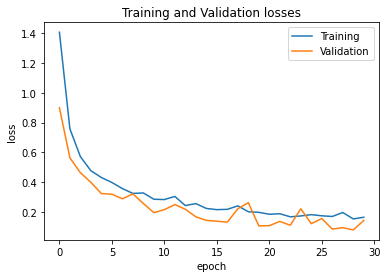

In [29]:
import matplotlib.pyplot as plt

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig( 'loss.jpg', dpi=500, bbox_inches = 'tight')

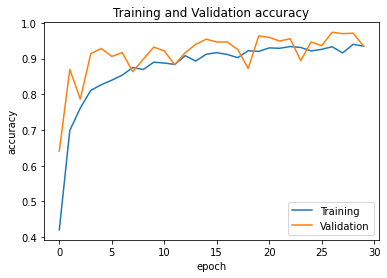

In [30]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig( 'accuracy.jpg', dpi=500, bbox_inches = 'tight')

In [31]:
y_pred = best_model.predict(test_images)
y_pred

30/30 [==============================] - 5s 147ms/step


array([[9.9906677e-01, 1.0469340e-04, 5.6213817e-10, 5.5185174e-20,
        3.7880280e-05, 7.9062569e-04],
       [2.2586556e-07, 9.9999976e-01, 4.3564058e-18, 1.4665735e-26,
        1.5982566e-12, 6.9353701e-10],
       [7.1402151e-06, 7.0683468e-09, 2.6490018e-06, 5.2448363e-18,
        9.6246862e-01, 3.7521623e-02],
       ...,
       [1.6992162e-05, 9.9998295e-01, 5.5304809e-17, 8.9002954e-27,
        4.7171687e-11, 1.1772118e-08],
       [3.4176033e-02, 5.4436820e-03, 3.8404221e-07, 7.8684048e-14,
        1.7841043e-03, 9.5859575e-01],
       [2.9628487e-14, 4.3880307e-17, 5.9828982e-03, 9.9401712e-01,
        6.6898393e-09, 2.0402711e-08]], dtype=float32)

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

print('classification report')
print( classification_report(test_images.labels,np.argmax(y_pred, axis=1)))

classification report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       160
           1       1.00      0.97      0.98       160
           2       0.99      1.00      0.99       160
           3       1.00      0.99      0.99       160
           4       0.96      0.91      0.93       160
           5       0.90      0.96      0.93       160

    accuracy                           0.97       960
   macro avg       0.97      0.97      0.97       960
weighted avg       0.97      0.97      0.97       960



[[157   0   0   0   0   3]
 [  5 155   0   0   0   0]
 [  0   0 160   0   0   0]
 [  0   0   2 158   0   0]
 [  0   0   0   0 145  15]
 [  0   0   0   0   6 154]]


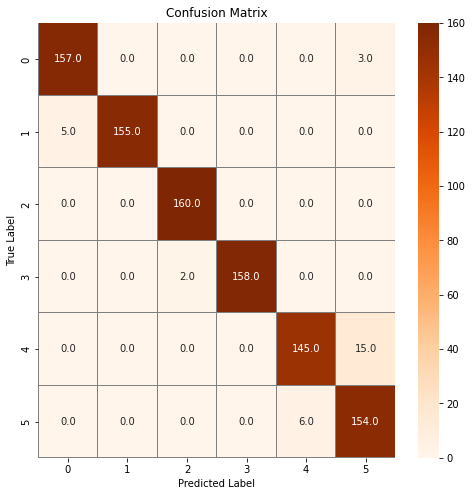

In [38]:
import seaborn as sns
cm = confusion_matrix(test_images.labels, np.argmax(y_pred, axis=1))
print(cm)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()